# Segment Anything EO

https://github.com/aliaksandr960/segment-anything-eo

This tool is developed to easy process spatial data (GeoTIFF and TMS) with Meta AI Segment Anything models

You can:
- download TMS data as GeoTIFF files
- process GeoTIFF files with Meta AI Segment Anything models
- save inference data as GeoTIFF raster data or GPKG vector data

## Clone repo and install dependancies

In [1]:
!git clone https://github.com/aliaksandr960/segment-anything-eo.git

Cloning into 'segment-anything-eo'...
remote: Enumerating objects: 134, done.
remote: Counting objects: 100% (134/134), done.
remote: Compressing objects: 100% (98/98), done.
remote: Total 134 (delta 17), reused 127 (delta 12), pack-reused 0
Receiving objects: 100% (134/134), 26.87 MiB | 11.53 MiB/s, done.
Resolving deltas: 100% (17/17), done.


In [2]:
import os
os.chdir('/content/segment-anything-eo')

In [3]:
!pip install rasterio
!pip install geopandas

!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 61.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 51.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 41.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 25.3 MB/s eta 0:00:00
--2023-04-08 23:39:00--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.224.249.63, 13.224.249.94, 13.224.249.83, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.224.249.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39

In [4]:
import cv2
import matplotlib.pyplot as plt
from sameo import SamEO

## Initialize SemEO class

In [5]:
# Availble SamEO arguments:
# checkpoint="sam_vit_h_4b8939.pth",
# model_type='vit_h',
# device='cpu',
# erosion_kernel=(3, 3),
# mask_multiplier=255,
# sam_kwargs=None

# Availble sam_kwargs:
# points_per_side: Optional[int] = 32,
# points_per_batch: int = 64,
# pred_iou_thresh: float = 0.88,
# stability_score_thresh: float = 0.95,
# stability_score_offset: float = 1.0,
# box_nms_thresh: float = 0.7,
# crop_n_layers: int = 0,
# crop_nms_thresh: float = 0.7,
# crop_overlap_ratio: float = 512 / 1500,
# crop_n_points_downscale_factor: int = 1,
# point_grids: Optional[List[np.ndarray]] = None,
# min_mask_region_area: int = 0,
# output_mode: str = "binary_mask",

device = 'cuda:0'

sam_eo = SamEO(checkpoint="sam_vit_h_4b8939.pth",
               model_type='vit_h',
               device=device,
               erosion_kernel=(3, 3),
               mask_multiplier=255,
               sam_kwargs=None)

## Download file from Openaerialmap and save it

In [6]:
tms_source = 'https://tiles.openaerialmap.org/642385491a8878000512126c/0/642385491a8878000512126d/{z}/{x}/{y}'
pt1 = (29.676840, -95.369222)
pt2 = (29.678559, -95.367314)
zoom = 20
tms_tiff_path = 'test_tms_image.tif'

image = sam_eo.download_tms_as_tiff(tms_source, pt1, pt2, zoom, tms_tiff_path)
tiff_image = cv2.cvtColor(cv2.imread(tms_tiff_path), cv2.COLOR_BGR2RGB)

42it [00:00, 78.07it/s]


<Figure size 640x480 with 0 Axes>

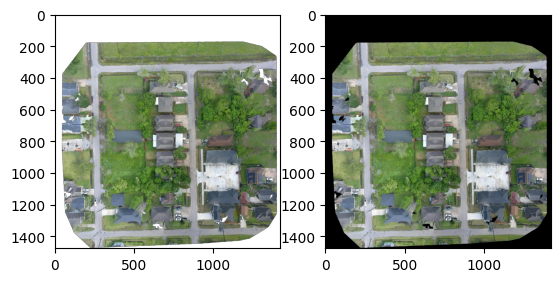

In [7]:
plt.figure()
f, axarr = plt.subplots(1,2)
axarr[0].imshow(image)
axarr[1].imshow(tiff_image)
plt.show()

## Run inference and save result as tiff file

In [8]:
pred_tiff_path = 'pred.tiff'
sam_eo.tiff_to_tiff(tms_tiff_path, pred_tiff_path)

100%|██████████| 16/16 [01:36<00:00,  6.00s/it]


<Figure size 640x480 with 0 Axes>

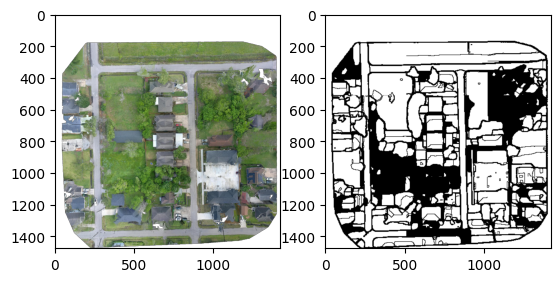

In [9]:
pred_image = cv2.cvtColor(cv2.imread(pred_tiff_path), cv2.COLOR_BGR2RGB)

plt.figure()
f, axarr = plt.subplots(1,2)
axarr[0].imshow(image)
axarr[1].imshow(pred_image)
plt.show()

## Polygonize result and save as GPKG file

In [10]:
# Adjust simplification tolerance to reduce size (it could be bigger, than raster)
sam_eo.tiff_to_gpkg(pred_tiff_path, 'pred.gpkg', simplify_tolerance=None)